In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import scipy
%matplotlib inline
from brian2.units import *
plt.viridis()
from matplotlib import animation, rc
from IPython.display import HTML
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
import matplotlib as mlib
mlib.rcParams.update({'font.size': 22})
mlib.rcParams.update({'errorbar.capsize': 5})

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import sys
import cv2
import bz2
import pickle

#class_9__005949_samples__width_028__height_028__off_channel__midLevel_069__maxRate_50
def load_rates(in_path, class_idx, min_noise=0, max_noise=0,
                     mean_rate=None,
                     suffix=None):
    from tempfile import mkdtemp
    import os
    import glob

    ON, OFF = 0, 1
    IDX, RATE = 0, 1

    def load_compressed(fname):
        with bz2.BZ2File(fname, 'rb') as f:
            obj = pickle.load(f)
            return obj

    if suffix is not None:
        fnames = glob.glob(os.path.join(in_path, "*%s.pickle.bz2" % suffix))
    else:
        fnames = glob.glob(os.path.join(in_path, "*.pickle.bz2"))

    #     print(fnames)
    on_rates = None
    off_rates = None
    for fname in fnames:
        spl = os.path.basename(fname).split('__')
        cls = int(spl[0].split('_')[1])
        if cls == class_idx:
            n_smpls = int(spl[1].split('_')[0])
            width = int(spl[2].split('_')[1])
            height = int(spl[3].split('_')[1])
            if mean_rate is not None:
                new_rate = float(width * height * mean_rate)
            on_rates, off_rates = None, None
            data = load_compressed(fname)

            tmp_dir = mkdtemp()
            np.random.seed()
            filename = os.path.join(tmp_dir, 'on_rates.dat')
            on_rates = np.memmap(filename, dtype='uint16', mode='w+',
                                 shape=(n_smpls, height, width))
            on_rates[:] = np.round(np.random.uniform(min_noise, max_noise,
                                                     size=(n_smpls, height,
                                                           width))).astype(
                'uint16')
            for i in xrange(len(data[ON][IDX])):
                for idx in data[ON][IDX][i]:
                    r = idx // width
                    c = idx % width
                    if mean_rate is None:
                        on_rates[i, r, c] += data[ON][RATE][i]
                    else:
                        on_rates[i, r, c] += round(
                            new_rate / len(data[ON][IDX][i]))
            on_rates[on_rates < 0] = 0.

            np.random.seed()
            filename = os.path.join(tmp_dir, 'off_rates.dat')
            off_rates = np.memmap(filename, dtype='uint16', mode='w+',
                                  shape=(n_smpls, height, width))
            off_rates[:] = np.round(np.random.uniform(min_noise, max_noise,
                                                      size=(n_smpls, height,
                                                            width))).astype(
                'uint16')
            for i in xrange(len(data[OFF][IDX])):
                for idx in data[OFF][IDX][i]:
                    r = idx // width
                    c = idx % width
                    if mean_rate is None:
                        off_rates[i, r, c] += data[OFF][RATE][i]
                    else:
                        off_rates[i, r, c] += round(
                            new_rate / len(data[OFF][IDX][i]))

            off_rates[off_rates < 0] = 0.
            del data

    return on_rates, off_rates
rates_on, rates_off  = load_rates('centre_surround/', 0, suffix="CS")
rates_on_1, rates_off_1  = load_rates('centre_surround/', 1, suffix="CS")
print(rates_on.shape)

(5922L, 28L, 28L)


In [4]:
np.mean(np.mean(rates_on.reshape(5922, 28**2), axis=0))

20.067874287506292

In [5]:
np.sum(rates_on.reshape(5922L, 28**2))

93172090

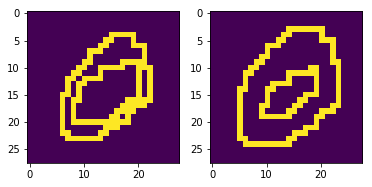

In [13]:
fig = plt.figure()
ax = plt.subplot(1, 2, 1)
plt.imshow(rates_on[0,:,:].reshape(28, 28), interpolation='none')
ax = plt.subplot(1, 2, 2)
plt.imshow(rates_off[0,:,:].reshape(28, 28), interpolation='none')
plt.show()

In [21]:
difference = np.array(rates_on[0,:,:], dtype="float")-rates_off[0,:,:]

In [22]:
difference.max()

136.0

In [23]:
difference.min()

-136.0

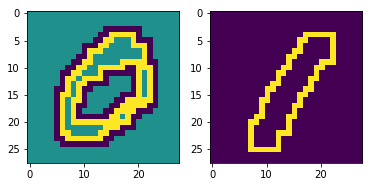

In [25]:
fig = plt.figure()
ax = plt.subplot(1, 2, 1)
plt.imshow((difference).reshape(28, 28), interpolation='none')
ax = plt.subplot(1, 2, 2)
plt.imshow((rates_on_1[0,:,:]-rates_off_1[0,:,:]).reshape(28, 28), interpolation='none')
plt.show()

[245] [0]


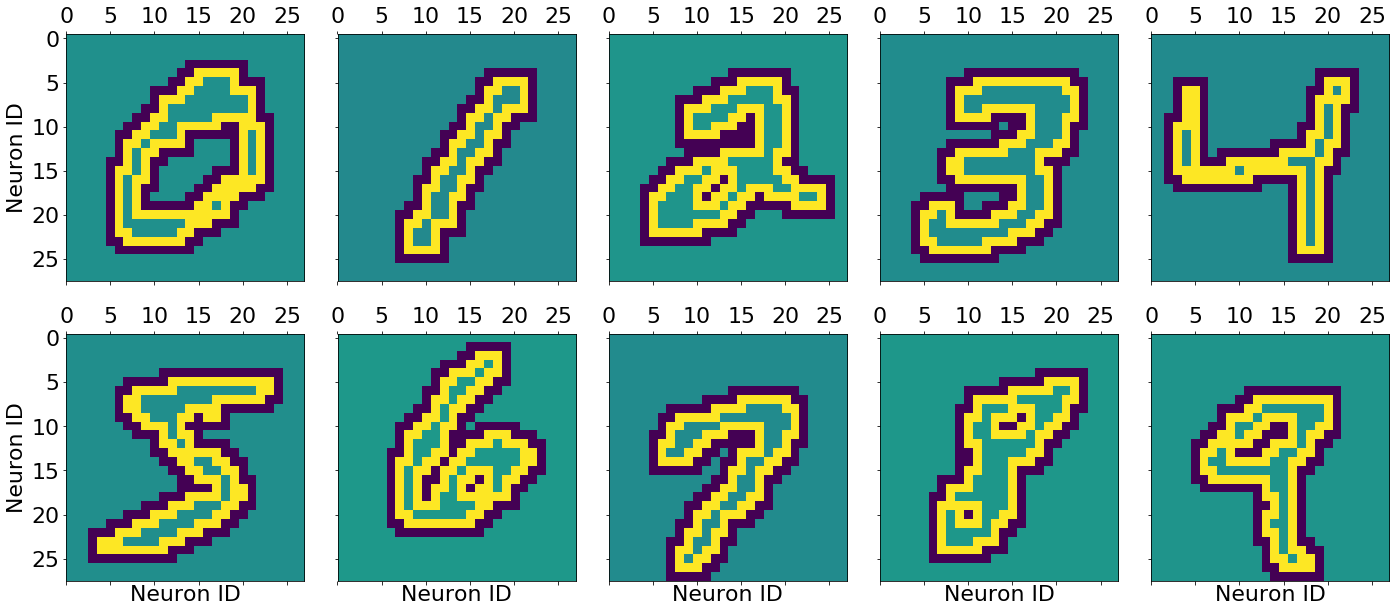

In [35]:
import matplotlib as mlib
mlib.rcParams.update({'font.size': 22})
mlib.rcParams.update({'errorbar.capsize': 5})
fig_conn, axes = plt.subplots(2, 5,figsize=(20, 9), dpi=800, sharey=True)

silly_ax = []
maximus = [-1]
minimus = [2**31]

for index, val in np.ndenumerate(axes):
    x, y = index
    source_hits = np.empty(28**2)
    rates_on, rates_off  = load_rates('centre_surround/', x*5+y, suffix="CS")
    source_hits= rates_on[0,:,:].reshape(28, 28)
    
    difference = np.array(rates_on[0,:,:], dtype="float")-rates_off[0,:,:]
    maximus = np.maximum(maximus, source_hits.max())
    minimus = np.minimum(minimus, source_hits.min())

    silly_ax.append(axes[x, y].matshow(difference.reshape(28, 28)))

# ff_conn_ax = axes[0, 0].matshow(source_hits.reshape(28, 28))
# weighted_conn_ax = axes[1, 1].matshow(source_weighted_hits.reshape(28, 28))
print maximus, minimus

# ax1.set_title("Hits\n")
# ax1.set_xlabel("Neuron ID")
axes[0, 0].set_ylabel("Neuron ID")
# ax2.set_title("Weighted hits\n")
# ax2.set_xlabel("Neuron ID")
axes[1, 0].set_ylabel("Neuron ID")

for arg in range(5):
    axes[1, arg].set_xlabel("Neuron ID")
    

# fig_conn.subplots_adjust(right=0.8)
# cbar_ax = fig_conn.add_axes([0.85, 0.15, 0.05, 0.7])
# fig_conn.colorbar(silly_ax[4], cax=cbar_ax)

# from mpl_toolkits.axes_grid1 import make_axes_locatable
# divider = make_axes_locatable(plt.gca())
# cax = divider.append_axes("right", "5%", pad="3%")
# plt.colorbar(silly_ax[4], cax=cax)

plt.tight_layout()
plt.savefig("input_digits_cs.png", dpi=600)
# plt.savefig("input_digits_cs.eps", dpi=800)
plt.show()

[212] [0]


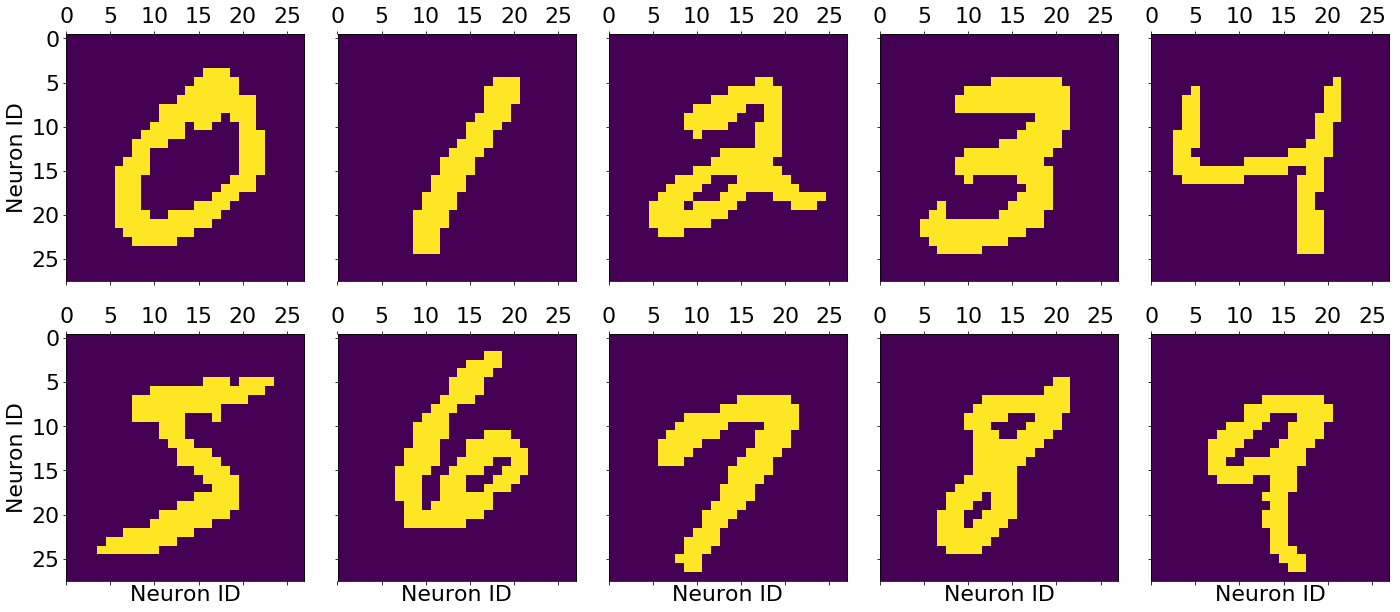

In [36]:
import matplotlib as mlib
mlib.rcParams.update({'font.size': 22})
mlib.rcParams.update({'errorbar.capsize': 5})
fig_conn, axes = plt.subplots(2, 5,figsize=(20, 9), dpi=800, sharey=True)

silly_ax = []
maximus = [-1]
minimus = [2**31]

for index, val in np.ndenumerate(axes):
    x, y = index
    source_hits = np.empty(28**2)
    rates_on, rates_off  = load_rates('averaged/', x*5+y)
    source_hits= rates_on[0,:,:].reshape(28, 28)
    
    difference = np.array(rates_on[0,:,:], dtype="float")-rates_off[0,:,:]
    maximus = np.maximum(maximus, source_hits.max())
    minimus = np.minimum(minimus, source_hits.min())

    silly_ax.append(axes[x, y].matshow(difference.reshape(28, 28)))

# ff_conn_ax = axes[0, 0].matshow(source_hits.reshape(28, 28))
# weighted_conn_ax = axes[1, 1].matshow(source_weighted_hits.reshape(28, 28))
print maximus, minimus

# ax1.set_title("Hits\n")
# ax1.set_xlabel("Neuron ID")
axes[0, 0].set_ylabel("Neuron ID")
# ax2.set_title("Weighted hits\n")
# ax2.set_xlabel("Neuron ID")
axes[1, 0].set_ylabel("Neuron ID")

for arg in range(5):
    axes[1, arg].set_xlabel("Neuron ID")
    

# fig_conn.subplots_adjust(right=0.8)
# cbar_ax = fig_conn.add_axes([0.85, 0.15, 0.05, 0.7])
# fig_conn.colorbar(silly_ax[4], cax=cbar_ax)

# from mpl_toolkits.axes_grid1 import make_axes_locatable
# divider = make_axes_locatable(plt.gca())
# cax = divider.append_axes("right", "5%", pad="3%")
# plt.colorbar(silly_ax[4], cax=cax)

plt.tight_layout()
plt.savefig("input_digits_rate_based.png", dpi=600)
# plt.savefig("input_digits_rate_based.eps", dpi=800)
plt.show()

In [28]:
print "Max on ", np.max(rates_on[0,:,:])
print "Max on ", np.min(rates_on[0,:,:])
print "Mean on ", np.mean(rates_on[0,:,:])
print "std on ", np.std(rates_on[0,:,:])

Max on  164
Max on  0
Mean on  20.0816326531
std on  53.759797108


In [13]:
rates_on.shape

(5922L, 28L, 28L)

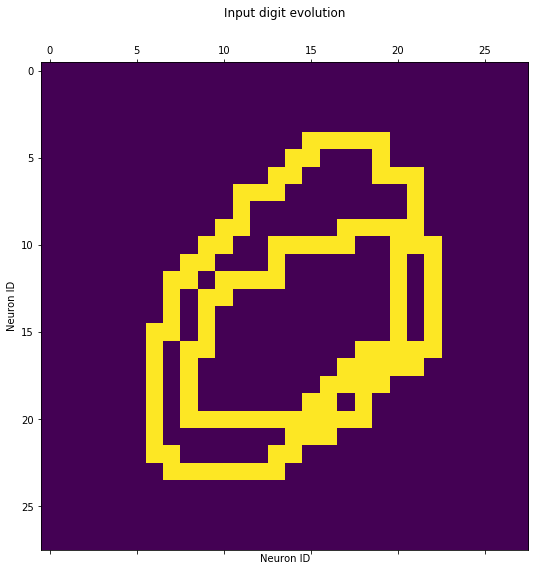

In [14]:
fig_conn, ax1 = plt.subplots(1, 1,figsize=(8,8))
    

ff_conn_ax = ax1.matshow(rates_on[0,:,:].reshape(28, 28))

ax1.set_title("Input digit evolution\n")
ax1.set_xlabel("Neuron ID")
ax1.set_ylabel("Neuron ID")
plt.tight_layout()
plt.show()

In [413]:
def init_conn():
#     line.set_data(input_rates/Hz)
#     ff_conn_ax.set_data(np.zeros((16,16)))
    return (ff_conn_ax, )

def animate_conn(i):
    global rates_on, rates_on_1
    
    if i < 61:
        ff_conn_ax.set_data(rates_on[i,:,:])
    else:
        ff_conn_ax.set_data(rates_on_1[i-11,:,:])
    return (ff_conn_ax,)

In [414]:
anim_conn = animation.FuncAnimation(fig_conn, animate_conn, init_func=init_conn,
                               frames=121, 
                            interval=1000, blit=True)

In [415]:
HTML(anim_conn.to_html5_video())

In [416]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, metadata=dict(artist='Petrut A Bogdan'), bitrate=-1)
anim_conn.save('mnist_digit_inputs.mp4', writer=writer)